In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
import sqlite3
import pandas as pd

db_path = "/content/drive/My Drive/database.sqlite"  # Update the path if needed
conn = sqlite3.connect(db_path)
cursor = conn.cursor()

cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()
print("Available tables:", tables)

Available tables: [('sqlite_sequence',), ('Player_Attributes',), ('Player',), ('Match',), ('League',), ('Country',), ('Team',), ('Team_Attributes',)]


In [11]:
tables = ["Player_Attributes", "Player", "Match", "League", "Country", "Team", "Team_Attributes"]

for table in tables:
    query = f"SELECT * FROM {table} LIMIT 5;"
    df = pd.read_sql(query, conn)
    print(f"\nTable: {table}")
    print(df.head(), "\n")


Table: Player_Attributes
   id  player_fifa_api_id  player_api_id                 date  overall_rating  \
0   1              218353         505942  2016-02-18 00:00:00              67   
1   2              218353         505942  2015-11-19 00:00:00              67   
2   3              218353         505942  2015-09-21 00:00:00              62   
3   4              218353         505942  2015-03-20 00:00:00              61   
4   5              218353         505942  2007-02-22 00:00:00              61   

   potential preferred_foot attacking_work_rate defensive_work_rate  crossing  \
0         71          right              medium              medium        49   
1         71          right              medium              medium        49   
2         66          right              medium              medium        49   
3         65          right              medium              medium        48   
4         65          right              medium              medium        48   



In [12]:
for table in tables:
    df = pd.read_sql(f"SELECT * FROM {table} LIMIT 100;", conn)
    print(f"\nMissing values in {table}:")
    print(df.isnull().sum(), "\n")


Missing values in Player_Attributes:
id                     0
player_fifa_api_id     0
player_api_id          0
date                   0
overall_rating         0
potential              0
preferred_foot         0
attacking_work_rate    0
defensive_work_rate    0
crossing               0
finishing              0
heading_accuracy       0
short_passing          0
volleys                0
dribbling              0
curve                  0
free_kick_accuracy     0
long_passing           0
ball_control           0
acceleration           0
sprint_speed           0
agility                0
reactions              0
balance                0
shot_power             0
jumping                0
stamina                0
strength               0
long_shots             0
aggression             0
interceptions          0
positioning            0
vision                 0
penalties              0
marking                0
standing_tackle        0
sliding_tackle         0
gk_diving              0
gk_handling 

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Load Match table
df_match = pd.read_sql("SELECT home_team_api_id, away_team_api_id, home_team_goal, away_team_goal FROM Match;", conn)

# Determine match result
def match_result(row):
    if row["home_team_goal"] > row["away_team_goal"]:
        return "Home Win"
    elif row["home_team_goal"] < row["away_team_goal"]:
        return "Away Win"
    else:
        return "Draw"

df_match["result"] = df_match.apply(match_result, axis=1)

# Count occurrences of each result type
match_counts = df_match["result"].value_counts(normalize=True) * 100  # Convert to percentage

<ipython-input-14-96477f090b93>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=match_counts.index, y=match_counts.values, palette=["green", "red", "blue"])


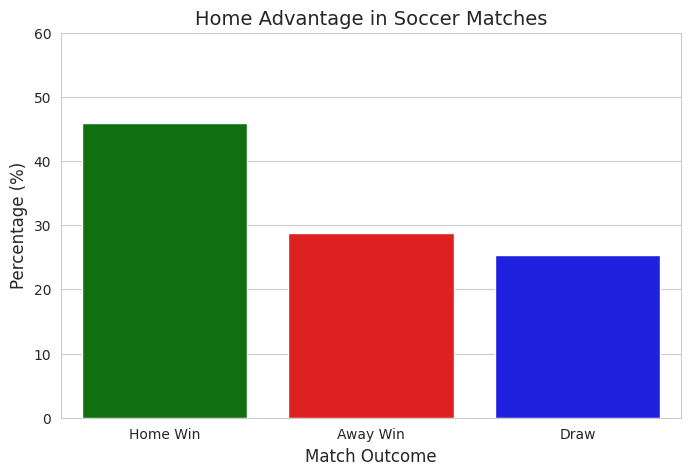

In [14]:
# Set seaborn style
sns.set_style("whitegrid")

# Create bar plot
plt.figure(figsize=(8, 5))
sns.barplot(x=match_counts.index, y=match_counts.values, palette=["green", "red", "blue"])

# Labels and title
plt.xlabel("Match Outcome", fontsize=12)
plt.ylabel("Percentage (%)", fontsize=12)
plt.title("Home Advantage in Soccer Matches", fontsize=14)
plt.ylim(0, 60)  # Adjust y-axis range
plt.show()

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Load Player Attributes table
df_players = pd.read_sql("SELECT overall_rating, stamina, strength, agility, acceleration FROM Player_Attributes;", conn)

# Drop rows with missing values
df_players = df_players.dropna()

# Display basic statistics
df_players.describe()

,overall_rating,stamina,strength,agility,acceleration
count,181265.000000,181265.000000,181265.000000,181265.000000,181265.000000
mean,68.621493,67.041751,67.424048,65.970910,67.694326
std,7.029845,13.189763,12.081658,12.954585,13.001383
min,33.000000,10.000000,10.000000,11.000000,10.000000
25%,64.000000,61.000000,60.000000,58.000000,61.000000
50%,69.000000,69.000000,69.000000,68.000000,69.000000
75%,73.000000,76.000000,76.000000,75.000000,77.000000
max,94.000000,96.000000,96.000000,96.000000,97.000000


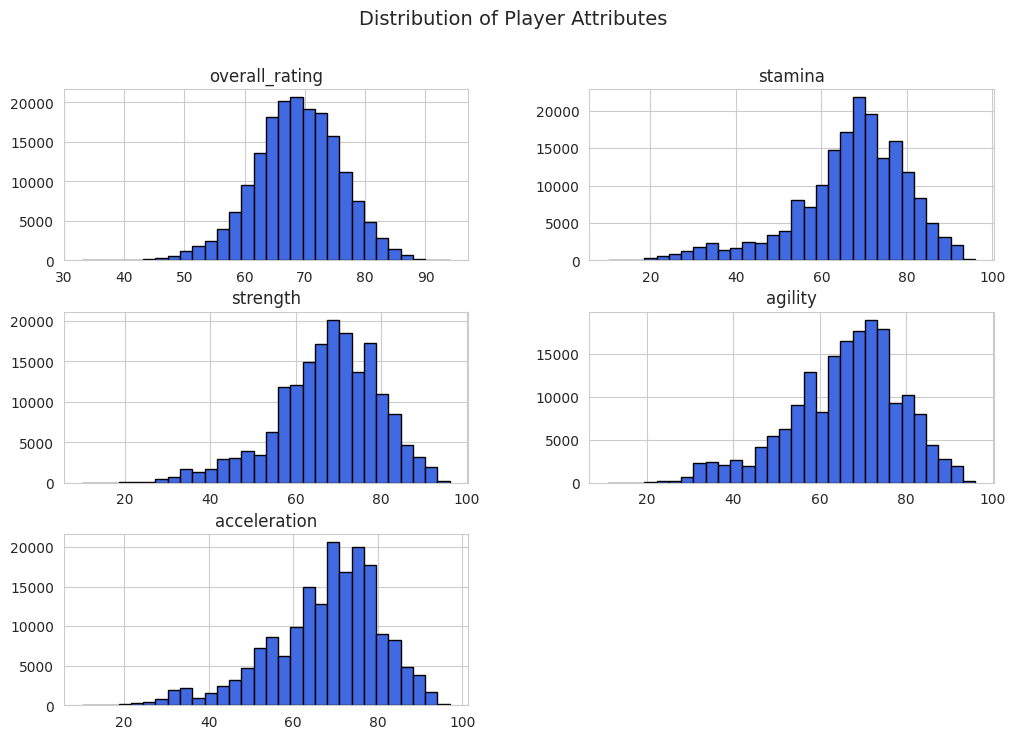

In [16]:
# Set seaborn style
sns.set_style("whitegrid")

# Create histograms for player attributes
df_players.hist(figsize=(12, 8), bins=30, color='royalblue', edgecolor='black')

# Show plot
plt.suptitle("Distribution of Player Attributes", fontsize=14)
plt.show()

In [17]:
# Load necessary match data
df_matches = pd.read_sql("""
    SELECT season, home_team_api_id, away_team_api_id, home_team_goal, away_team_goal
    FROM Match
    """, conn)

# Assign points based on match results
df_matches['home_team_points'] = df_matches.apply(lambda row: 3 if row['home_team_goal'] > row['away_team_goal'] else (1 if row['home_team_goal'] == row['away_team_goal'] else 0), axis=1)
df_matches['away_team_points'] = df_matches.apply(lambda row: 3 if row['away_team_goal'] > row['home_team_goal'] else (1 if row['home_team_goal'] == row['away_team_goal'] else 0), axis=1)

# Aggregate points per season for home and away teams
df_team_performance = df_matches.groupby(['season', 'home_team_api_id'])['home_team_points'].sum().reset_index()
df_team_performance.rename(columns={'home_team_api_id': 'team_api_id', 'home_team_points': 'total_points'}, inplace=True)

df_away_performance = df_matches.groupby(['season', 'away_team_api_id'])['away_team_points'].sum().reset_index()
df_away_performance.rename(columns={'away_team_api_id': 'team_api_id', 'away_team_points': 'total_points'}, inplace=True)

# Combine home and away performance
df_total_performance = pd.concat([df_team_performance, df_away_performance]).groupby(['season', 'team_api_id'])['total_points'].sum().reset_index()

# Load team names
df_teams = pd.read_sql("SELECT team_api_id, team_long_name FROM Team;", conn)
df_total_performance = df_total_performance.merge(df_teams, on='team_api_id', how='left')

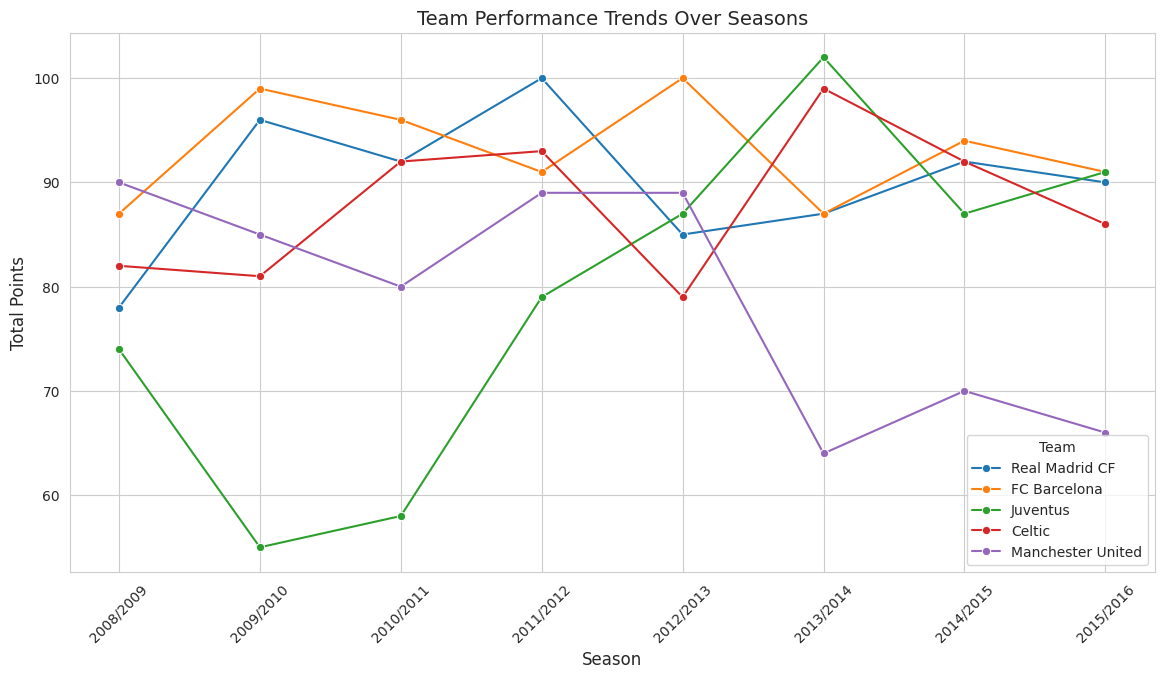

In [18]:
plt.figure(figsize=(14, 7))

# Select top teams to visualize (modify this to select specific teams)
top_teams = df_total_performance.groupby('team_long_name')['total_points'].sum().nlargest(5).index
df_top_teams = df_total_performance[df_total_performance['team_long_name'].isin(top_teams)]

# Plot performance trends
sns.lineplot(data=df_top_teams, x="season", y="total_points", hue="team_long_name", marker="o")

plt.title("Team Performance Trends Over Seasons", fontsize=14)
plt.xlabel("Season", fontsize=12)
plt.ylabel("Total Points", fontsize=12)
plt.legend(title="Team")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [26]:
# Check the columns of the Player_Attributes table
cursor.execute("PRAGMA table_info(Player_Attributes);")
columns = cursor.fetchall()
print(columns)

[(0, 'id', 'INTEGER', 0, None, 1), (1, 'player_fifa_api_id', 'INTEGER', 0, None, 0), (2, 'player_api_id', 'INTEGER', 0, None, 0), (3, 'date', 'TEXT', 0, None, 0), (4, 'overall_rating', 'INTEGER', 0, None, 0), (5, 'potential', 'INTEGER', 0, None, 0), (6, 'preferred_foot', 'TEXT', 0, None, 0), (7, 'attacking_work_rate', 'TEXT', 0, None, 0), (8, 'defensive_work_rate', 'TEXT', 0, None, 0), (9, 'crossing', 'INTEGER', 0, None, 0), (10, 'finishing', 'INTEGER', 0, None, 0), (11, 'heading_accuracy', 'INTEGER', 0, None, 0), (12, 'short_passing', 'INTEGER', 0, None, 0), (13, 'volleys', 'INTEGER', 0, None, 0), (14, 'dribbling', 'INTEGER', 0, None, 0), (15, 'curve', 'INTEGER', 0, None, 0), (16, 'free_kick_accuracy', 'INTEGER', 0, None, 0), (17, 'long_passing', 'INTEGER', 0, None, 0), (18, 'ball_control', 'INTEGER', 0, None, 0), (19, 'acceleration', 'INTEGER', 0, None, 0), (20, 'sprint_speed', 'INTEGER', 0, None, 0), (21, 'agility', 'INTEGER', 0, None, 0), (22, 'reactions', 'INTEGER', 0, None, 0), (

In [27]:
# Load the player attributes data
query = "SELECT * FROM Player_Attributes LIMIT 10;"
df_player_attributes = pd.read_sql(query, conn)

# Inspect the first few rows of the data
df_player_attributes.head()

,id,player_fifa_api_id,player_api_id,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
0,1,218353,505942,2016-02-18 00:00:00,67,71,right,medium,medium,49,...,54,48,65,69,69,6,11,10,8,8
1,2,218353,505942,2015-11-19 00:00:00,67,71,right,medium,medium,49,...,54,48,65,69,69,6,11,10,8,8
2,3,218353,505942,2015-09-21 00:00:00,62,66,right,medium,medium,49,...,54,48,65,66,69,6,11,10,8,8
3,4,218353,505942,2015-03-20 00:00:00,61,65,right,medium,medium,48,...,53,47,62,63,66,5,10,9,7,7
4,5,218353,505942,2007-02-22 00:00:00,61,65,right,medium,medium,48,...,53,47,62,63,66,5,10,9,7,7


In [30]:
# Select relevant features for the model
features = ['crossing', 'finishing', 'heading_accuracy', 'short_passing', 'dribbling', 'free_kick_accuracy', 'long_passing']
X = df_player_attributes[features]
y = df_player_attributes['overall_rating']

# Handling missing values if any
X = X.fillna(X.mean())

# Split data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a RandomForestRegressor model
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor()
model.fit(X_train, y_train)

# Predict and evaluate the model
y_pred = model.predict(X_test)

# Calculate the accuracy of the model (R-squared score for regression)
from sklearn.metrics import mean_absolute_error, r2_score
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Absolute Error:", mae)
print("R-squared:", r2)

Mean Absolute Error: 1.5849999999999937
R-squared: 0.4658388888888909
